In [ ]:
# from transformers import SegformerForSemanticSegmentation

/home/yumin/miniconda3/envs/ccp_kaggle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from model import get_model
from beit_model import get_temp_model
import torch.nn.functional as F
from torchvision import models

/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class VOCDataset(Dataset):
    def __init__(self, root="./dataset/pascal_2012/VOCdevkit/VOC2012",
                 is_train=True, transform=None, classes=None):
        # Choose the file for training or validation images
        if is_train:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "train.txt")
        else:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "val.txt")
        
        # Get image names into list
        img_names = []
        with open(img_root, 'r') as rf:
            names = [name.replace('\n','') for name in rf.readlines()]
            for name in names:
                img_names.append(name)
            
        self.classes =  classes
        self.transform = transform
        self.img_names = img_names
        self.root = root
        
    def __len__(self):
        return len(self.img_names)
    
    def _convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # Initialize an empty mask with a channel for each class
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)))
        
        # Create a mask for each class label
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        
        return segmentation_mask

    
    def __getitem__(self, item):
        img_name = self.img_names[item]
        # Load the image and corresponding mask
        img = cv2.imread(os.path.join(self.root, "JPEGImages", img_name + ".jpg"))
        mask = cv2.imread(os.path.join(self.root, "SegmentationClass", img_name + ".png"))
        
        # Convert BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert RGB mask to segmentation mask
        mask = self._convert_to_segmentation_mask(mask)
        
        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.argmax(dim=2).squeeze()  # Convert multi-channel mask back to single-channel
        
        return img, mask

In [3]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
trainsform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(),
])

VOC_dataset = VOCDataset(is_train= True, transform = trainsform)

# /home/oaz/yumin/CCP_2024/.dataset/pascal_2012/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt

375 79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Img: torch.Size([3, 224, 224])
Mask: torch.Size([224, 224])
Max Value Img: tensor(2.4657)
Max Value Mask: 16 | Unique Value Mask: tensor([ 0, 16])


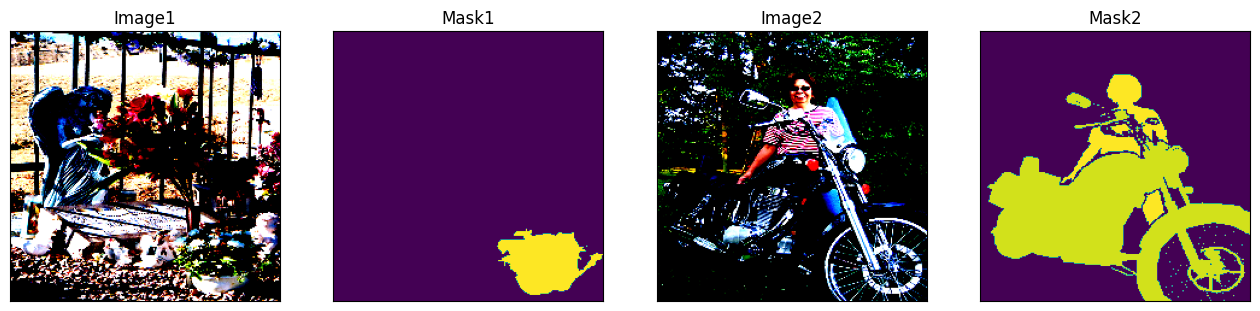

In [5]:
idx1, idx2 = np.random.randint(1,500), np.random.randint(1,500)
print(idx1,idx2)
img, mask = VOC_dataset[idx1]
img2, mask2 = VOC_dataset[idx2]
print("Img:", img.shape)
print("Mask:", mask.shape)
print("Max Value Img:",img.max())
print("Max Value Mask: {} | Unique Value Mask: {}".format(mask.max(), mask.unique()))

visualize(
    image1=img.permute(1,2,0), 
    mask1=mask.squeeze(),
    image2 = img2.permute(1,2,0),
    mask2 = mask2.squeeze(),
)

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [7]:
# transform_size = 257
#Define trainform to images
def img_transform(trainsize= 512):
    train_transform = A.Compose([
    A.Rotate([-10,10]),
    A.RandomScale([0.5,2]),
    A.GaussianBlur(),
    A.HorizontalFlip(),
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(width=trainsize, height=trainsize),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(), 
    ])
    return train_transform, test_transform

In [8]:
import copy

#patience, min_delta, restore_best_weights, best_model, best_loss counter status
#copy.deepcopy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Call method to check if early stopping is triggered.

        Args:
        model (torch.nn.Module): The model being trained.
        val_loss (float): The validation loss of the current epoch.

        Returns:
        bool: True if early stopping should occur, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stop on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True  # Stop training
        self.status = f"{self.counter}/{self.patience}"
        return False # Continue training

In [9]:
import matplotlib.pyplot as plt

def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Test Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)

In [11]:
# Training fuction
def train(model,train_dataloader,device,optimizer, epoch, EPOCHS, writer, train_loss_meter, criterion):
    model.train()
    train_progress= tqdm(train_dataloader, colour="cyan")
    
    for idx, img_mask in enumerate(train_progress):
        img = img_mask[0].float().to(device) #img - B,C,H,W
        mask = img_mask[1].long().to(device) #label - B,H,W
        
        y_pred = model(img)['out']
        
        # y_pred = model(img) #B, 21, H, W
        # y_pred =  upsample(y_pred)
        #Optimizer 
        optimizer.zero_grad()
        loss = criterion(y_pred, mask) 
        loss.backward()
        optimizer.step()
        
        train_loss_meter.update(loss.item())
        
        # tracking the loss function
        writer.add_scalar("Train/Loss", train_loss_meter.avg, epoch*len(train_dataloader)+idx)
        
        train_progress.set_description("TRAIN| Epoch: {}/{}| Iter: {}/{} | Train Loss: {:0.4f} | lr: {}".format(
            epoch+1, EPOCHS, idx, len(train_dataloader), loss, optimizer.param_groups[0]['lr']))
        
    return train_loss_meter.avg

In [12]:
#Evaluate function
def evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion):
    model.eval()
    
    with torch.no_grad():
        for idx, img_mask in enumerate(val_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device) #B W H

            # y_pred = model(img) #B, 21, H, W
            # y_pred =  upsample(y_pred)
            
            y_pred = model(img)['out']

            # y_pred = model(img).logits #B, 21, H, W
            # y_pred = upsample(y_pred)
            
            loss = criterion(y_pred, mask) 
            test_loss_meter.update(loss.item()) 
            
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            y_pred = y_pred.argmax(dim=1).squeeze(dim=1)
            intersection, union, target = intersectionAndUnionGPU(y_pred.float(), mask.float(), num_classes)
            intersection, union, target = intersection.cpu().numpy(), union.cpu().numpy(), target.cpu().numpy()
            intersection_meter.update(intersection), union_meter.update(union), target_meter.update(target)
            
            if idx>35: break
            
        #compute acc, iou, dice
        accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
        macc = np.mean(accuracy_class)
        miou = np.mean(iou_class) #mean vector 21D
        mdice = np.mean(dice_class) #mean vector 21D
        
    return macc, miou, mdice, test_loss_meter.avg

In [13]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F

import segmentation_models_pytorch as smp
import shutil
from tqdm import tqdm
# from transformers import SegformerForSemanticSegmentation, SegformerConfig

In [14]:
def main(learning_rate, batch_size, epochs, num_workers, data_path, model_save_path, tensorboard_path, num_classes, checkpoint_path):
    
    # Create model save directory if it doesn't exist
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    # Creater tensorboard directory
    if os.path.isdir(tensorboard_path):
        shutil.rmtree(tensorboard_path)
    os.mkdir(tensorboard_path)
    
    
    # Data augmentation and preprocessing for training and testing
    train_transform, test_transform = img_transform()
    
    # Create datasets and dataloaders
    train_dataset = VOCDataset(is_train=True, transform=train_transform)
    test_dataset = VOCDataset(is_train=False, transform=test_transform)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    # Load model and move it to the appropriate device
    # segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
    # model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
    # model = get_model(num_classes=21)
    # model = get_temp_model(num_classes=21)
    model = models.segmentation.fcn_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(512, 21, kernel_size=1)
    # in_channels = model.decode_head.classifier.in_channels
    # model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model.to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = smp.losses.DiceLoss(mode="multiclass", classes = num_classes, log_loss = False, from_logits = True, smooth=1e-8)
    
    # Best validation IoU for saving the best model
    best_predict = -1
    current_epoch = 0
                                   
    # Metrics
    train_loss_list = []
    test_loss_list = []
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    
    # Early Stop
    es = EarlyStopping(patience=14,restore_best_weights=False)
    
    # set up learning rate scheduler
    scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold= 1e-4, min_lr=0)
     
    # difine Tensorboard    
    writer = SummaryWriter(tensorboard_path)
    
    
    # Training loop
    for epoch in range(current_epoch,epochs): #EPOCHS
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()
        
        #Start training model
        train_loss = train(model,train_dataloader,device,optimizer, epoch, epochs, writer, train_loss_meter,criterion)
        acc, miou, dice, test_loss = evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        # write in tensorboard
        writer.add_scalar("Test/Acc", acc, epoch)
        writer.add_scalar("Test/mIOU", miou, epoch)
        writer.add_scalar("Test/Dice", dice, epoch)
        
        # update learning rate
        scheduler.step(1-miou)

        #Create checkpoint
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch, 
            "optimizer_state_dict": optimizer.state_dict(),
            "miou": miou
        }
        
        # Save last checkpoint
        torch.save(checkpoint, os.path.join(model_save_path, "last.h5"))
        
        # Save best checkpoint based on dice score
        if miou > best_predict:
            torch.save(checkpoint, os.path.join(model_save_path, "best.h5"))
            best_predict = miou
            
        if es(model, 1-miou):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        print("VAL| Acc:{:0.4f}  | mIOU: {:0.4f} | Dice: {:0.4f} | Test Loss: {:0.4f}| EStop: {}".format(
             acc, miou, dice, test_loss, es.status))
        
    #show tracking plot
    plot_segmentation_metrics(train_loss_list, test_loss_list)

/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oaz/miniconda3/envs/ccp/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
TRAIN| Epoch: 1/50| Iter: 182/183 | Train Loss: 0.4142 | lr: 0.001: 100%|██████████| 183/183 [03:03<00:00,  1.00s/it]


VAL| Acc:0.0901  | mIOU: 0.0341 | Dice: 0.0511 | Test Loss: 0.4308| EStop: 0/14


TRAIN| Epoch: 2/50| Iter: 182/183 | Train Loss: 0.3709 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.0937  | mIOU: 0.0454 | Dice: 0.0636 | Test Loss: 0.4263| EStop: 0/14


TRAIN| Epoch: 3/50| Iter: 182/183 | Train Loss: 0.4530 | lr: 0.001: 100%|██████████| 183/183 [02:57<00:00,  1.03it/s]


VAL| Acc:0.1044  | mIOU: 0.0534 | Dice: 0.0787 | Test Loss: 0.4223| EStop: 0/14


TRAIN| Epoch: 4/50| Iter: 182/183 | Train Loss: 0.4991 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


VAL| Acc:0.1102  | mIOU: 0.0568 | Dice: 0.0847 | Test Loss: 0.4196| EStop: 0/14


TRAIN| Epoch: 5/50| Iter: 182/183 | Train Loss: 0.4145 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


VAL| Acc:0.1099  | mIOU: 0.0637 | Dice: 0.0951 | Test Loss: 0.4175| EStop: 0/14


TRAIN| Epoch: 6/50| Iter: 182/183 | Train Loss: 0.3619 | lr: 0.001: 100%|██████████| 183/183 [02:56<00:00,  1.04it/s]


VAL| Acc:0.1402  | mIOU: 0.0627 | Dice: 0.0986 | Test Loss: 0.4156| EStop: 1/14


TRAIN| Epoch: 7/50| Iter: 182/183 | Train Loss: 0.3599 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.03it/s]


VAL| Acc:0.1413  | mIOU: 0.0681 | Dice: 0.1066 | Test Loss: 0.4136| EStop: 0/14


TRAIN| Epoch: 8/50| Iter: 182/183 | Train Loss: 0.2982 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.1547  | mIOU: 0.0790 | Dice: 0.1250 | Test Loss: 0.4113| EStop: 0/14


TRAIN| Epoch: 9/50| Iter: 182/183 | Train Loss: 0.4042 | lr: 0.001: 100%|██████████| 183/183 [03:02<00:00,  1.00it/s]


VAL| Acc:0.1445  | mIOU: 0.0730 | Dice: 0.1145 | Test Loss: 0.4098| EStop: 1/14


TRAIN| Epoch: 10/50| Iter: 182/183 | Train Loss: 0.3786 | lr: 0.001: 100%|██████████| 183/183 [03:03<00:00,  1.00s/it]


VAL| Acc:0.1529  | mIOU: 0.0793 | Dice: 0.1255 | Test Loss: 0.4082| EStop: 0/14


TRAIN| Epoch: 11/50| Iter: 182/183 | Train Loss: 0.3129 | lr: 0.001: 100%|██████████| 183/183 [03:02<00:00,  1.01it/s]


VAL| Acc:0.1571  | mIOU: 0.0778 | Dice: 0.1239 | Test Loss: 0.4068| EStop: 1/14


TRAIN| Epoch: 12/50| Iter: 182/183 | Train Loss: 0.2987 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


VAL| Acc:0.1633  | mIOU: 0.0781 | Dice: 0.1239 | Test Loss: 0.4057| EStop: 2/14


TRAIN| Epoch: 13/50| Iter: 182/183 | Train Loss: 0.2349 | lr: 0.001: 100%|██████████| 183/183 [03:05<00:00,  1.02s/it]


VAL| Acc:0.1388  | mIOU: 0.0753 | Dice: 0.1166 | Test Loss: 0.4049| EStop: 3/14


TRAIN| Epoch: 14/50| Iter: 182/183 | Train Loss: 0.3077 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.02it/s]


VAL| Acc:0.1549  | mIOU: 0.0846 | Dice: 0.1341 | Test Loss: 0.4038| EStop: 0/14


TRAIN| Epoch: 15/50| Iter: 182/183 | Train Loss: 0.3072 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.1771  | mIOU: 0.0821 | Dice: 0.1322 | Test Loss: 0.4028| EStop: 1/14


TRAIN| Epoch: 16/50| Iter: 182/183 | Train Loss: 0.3260 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.1774  | mIOU: 0.0878 | Dice: 0.1401 | Test Loss: 0.4018| EStop: 0/14


TRAIN| Epoch: 17/50| Iter: 182/183 | Train Loss: 0.3813 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.02it/s]


VAL| Acc:0.1690  | mIOU: 0.0905 | Dice: 0.1448 | Test Loss: 0.4008| EStop: 0/14


TRAIN| Epoch: 18/50| Iter: 182/183 | Train Loss: 0.1957 | lr: 0.001: 100%|██████████| 183/183 [02:54<00:00,  1.05it/s]


VAL| Acc:0.1983  | mIOU: 0.0983 | Dice: 0.1587 | Test Loss: 0.3996| EStop: 0/14


TRAIN| Epoch: 19/50| Iter: 182/183 | Train Loss: 0.4506 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.1819  | mIOU: 0.0949 | Dice: 0.1529 | Test Loss: 0.3988| EStop: 1/14


TRAIN| Epoch: 20/50| Iter: 182/183 | Train Loss: 0.3147 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.03it/s]


VAL| Acc:0.1650  | mIOU: 0.0853 | Dice: 0.1363 | Test Loss: 0.3983| EStop: 2/14


TRAIN| Epoch: 21/50| Iter: 182/183 | Train Loss: 0.2796 | lr: 0.001: 100%|██████████| 183/183 [03:04<00:00,  1.01s/it]


VAL| Acc:0.1989  | mIOU: 0.0926 | Dice: 0.1495 | Test Loss: 0.3974| EStop: 3/14


TRAIN| Epoch: 22/50| Iter: 182/183 | Train Loss: 0.3404 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.03it/s]


VAL| Acc:0.2108  | mIOU: 0.1053 | Dice: 0.1685 | Test Loss: 0.3963| EStop: 0/14


TRAIN| Epoch: 23/50| Iter: 182/183 | Train Loss: 0.4291 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


VAL| Acc:0.2200  | mIOU: 0.1022 | Dice: 0.1647 | Test Loss: 0.3953| EStop: 1/14


TRAIN| Epoch: 24/50| Iter: 182/183 | Train Loss: 0.4186 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.2092  | mIOU: 0.1019 | Dice: 0.1645 | Test Loss: 0.3945| EStop: 2/14


TRAIN| Epoch: 25/50| Iter: 182/183 | Train Loss: 0.3638 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


VAL| Acc:0.2369  | mIOU: 0.1113 | Dice: 0.1811 | Test Loss: 0.3933| EStop: 0/14


TRAIN| Epoch: 26/50| Iter: 182/183 | Train Loss: 0.2931 | lr: 0.001: 100%|██████████| 183/183 [02:57<00:00,  1.03it/s]


VAL| Acc:0.2262  | mIOU: 0.1067 | Dice: 0.1724 | Test Loss: 0.3925| EStop: 1/14


TRAIN| Epoch: 27/50| Iter: 182/183 | Train Loss: 0.2978 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


VAL| Acc:0.2289  | mIOU: 0.1153 | Dice: 0.1857 | Test Loss: 0.3915| EStop: 0/14


TRAIN| Epoch: 28/50| Iter: 182/183 | Train Loss: 0.3447 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.02it/s]


VAL| Acc:0.2260  | mIOU: 0.1082 | Dice: 0.1743 | Test Loss: 0.3907| EStop: 1/14


TRAIN| Epoch: 29/50| Iter: 182/183 | Train Loss: 0.3482 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.2217  | mIOU: 0.1144 | Dice: 0.1832 | Test Loss: 0.3899| EStop: 2/14


TRAIN| Epoch: 30/50| Iter: 182/183 | Train Loss: 0.2392 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.2107  | mIOU: 0.1174 | Dice: 0.1885 | Test Loss: 0.3891| EStop: 0/14


TRAIN| Epoch: 31/50| Iter: 182/183 | Train Loss: 0.2549 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.2015  | mIOU: 0.1105 | Dice: 0.1776 | Test Loss: 0.3886| EStop: 1/14


TRAIN| Epoch: 32/50| Iter: 182/183 | Train Loss: 0.3140 | lr: 0.001: 100%|██████████| 183/183 [03:02<00:00,  1.00it/s]


VAL| Acc:0.2366  | mIOU: 0.1179 | Dice: 0.1892 | Test Loss: 0.3878| EStop: 0/14


TRAIN| Epoch: 33/50| Iter: 182/183 | Train Loss: 0.4146 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.2294  | mIOU: 0.1123 | Dice: 0.1831 | Test Loss: 0.3871| EStop: 1/14


TRAIN| Epoch: 34/50| Iter: 182/183 | Train Loss: 0.3812 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.2459  | mIOU: 0.1262 | Dice: 0.2019 | Test Loss: 0.3863| EStop: 0/14


TRAIN| Epoch: 35/50| Iter: 182/183 | Train Loss: 0.3369 | lr: 0.001: 100%|██████████| 183/183 [03:03<00:00,  1.00s/it]


VAL| Acc:0.2625  | mIOU: 0.1240 | Dice: 0.2010 | Test Loss: 0.3854| EStop: 1/14


TRAIN| Epoch: 36/50| Iter: 182/183 | Train Loss: 0.4021 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.03it/s]


VAL| Acc:0.2607  | mIOU: 0.1282 | Dice: 0.2077 | Test Loss: 0.3846| EStop: 0/14


TRAIN| Epoch: 37/50| Iter: 182/183 | Train Loss: 0.3973 | lr: 0.001: 100%|██████████| 183/183 [03:02<00:00,  1.00it/s]


VAL| Acc:0.2698  | mIOU: 0.1322 | Dice: 0.2128 | Test Loss: 0.3837| EStop: 0/14


TRAIN| Epoch: 38/50| Iter: 182/183 | Train Loss: 0.3538 | lr: 0.001: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


VAL| Acc:0.2671  | mIOU: 0.1264 | Dice: 0.2047 | Test Loss: 0.3829| EStop: 1/14


TRAIN| Epoch: 39/50| Iter: 182/183 | Train Loss: 0.3148 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


VAL| Acc:0.2666  | mIOU: 0.1244 | Dice: 0.2008 | Test Loss: 0.3823| EStop: 2/14


TRAIN| Epoch: 40/50| Iter: 182/183 | Train Loss: 0.4085 | lr: 0.001: 100%|██████████| 183/183 [03:07<00:00,  1.02s/it]


VAL| Acc:0.2212  | mIOU: 0.1265 | Dice: 0.2026 | Test Loss: 0.3818| EStop: 3/14


TRAIN| Epoch: 41/50| Iter: 182/183 | Train Loss: 0.3874 | lr: 0.001: 100%|██████████| 183/183 [02:55<00:00,  1.04it/s]


VAL| Acc:0.2708  | mIOU: 0.1336 | Dice: 0.2142 | Test Loss: 0.3810| EStop: 0/14


TRAIN| Epoch: 42/50| Iter: 182/183 | Train Loss: 0.4032 | lr: 0.001: 100%|██████████| 183/183 [02:55<00:00,  1.04it/s]


VAL| Acc:0.2831  | mIOU: 0.1455 | Dice: 0.2333 | Test Loss: 0.3801| EStop: 0/14


TRAIN| Epoch: 43/50| Iter: 182/183 | Train Loss: 0.2886 | lr: 0.001: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


VAL| Acc:0.2599  | mIOU: 0.1370 | Dice: 0.2192 | Test Loss: 0.3794| EStop: 1/14


TRAIN| Epoch: 44/50| Iter: 182/183 | Train Loss: 0.3685 | lr: 0.001: 100%|██████████| 183/183 [03:05<00:00,  1.01s/it]


VAL| Acc:0.2890  | mIOU: 0.1396 | Dice: 0.2248 | Test Loss: 0.3787| EStop: 2/14


TRAIN| Epoch: 45/50| Iter: 182/183 | Train Loss: 0.3060 | lr: 0.001: 100%|██████████| 183/183 [02:58<00:00,  1.02it/s]


VAL| Acc:0.2822  | mIOU: 0.1369 | Dice: 0.2209 | Test Loss: 0.3780| EStop: 3/14


TRAIN| Epoch: 46/50| Iter: 182/183 | Train Loss: 0.3207 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.2575  | mIOU: 0.1331 | Dice: 0.2133 | Test Loss: 0.3776| EStop: 4/14


TRAIN| Epoch: 47/50| Iter: 182/183 | Train Loss: 0.2954 | lr: 0.001: 100%|██████████| 183/183 [02:56<00:00,  1.04it/s]


VAL| Acc:0.3137  | mIOU: 0.1670 | Dice: 0.2639 | Test Loss: 0.3766| EStop: 0/14


TRAIN| Epoch: 48/50| Iter: 182/183 | Train Loss: 0.2501 | lr: 0.001: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


VAL| Acc:0.2874  | mIOU: 0.1437 | Dice: 0.2301 | Test Loss: 0.3760| EStop: 1/14


TRAIN| Epoch: 49/50| Iter: 182/183 | Train Loss: 0.4318 | lr: 0.001: 100%|██████████| 183/183 [03:03<00:00,  1.00s/it]


VAL| Acc:0.2781  | mIOU: 0.1541 | Dice: 0.2449 | Test Loss: 0.3753| EStop: 2/14


TRAIN| Epoch: 50/50| Iter: 182/183 | Train Loss: 0.3691 | lr: 0.001: 100%|██████████| 183/183 [03:02<00:00,  1.00it/s]


VAL| Acc:0.2931  | mIOU: 0.1492 | Dice: 0.2381 | Test Loss: 0.3747| EStop: 3/14


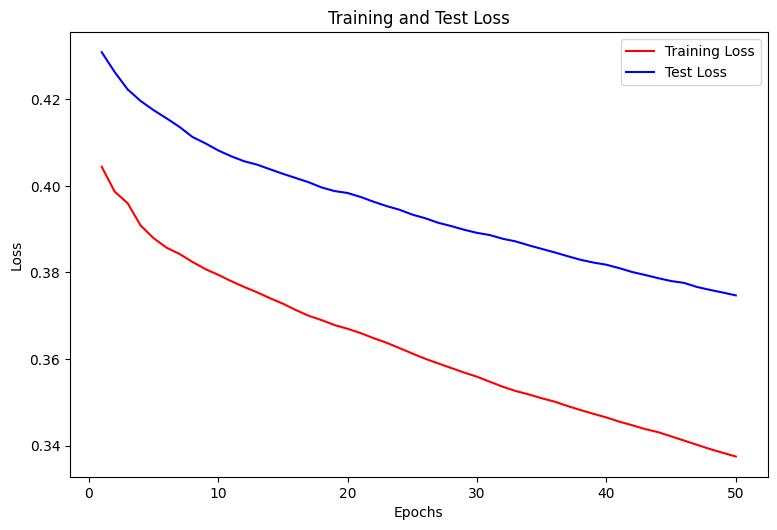

In [15]:
if __name__ == '__main__':
    # Hyperparameters and paths
    learning_rate = 1e-3
    batch_size = 8
    epochs = 50
    num_workers = os.cpu_count()
    data_path = "data"
    model_save_path = "./working/trained_model"
    tensorboard_path = "./working/tensorboard"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    if not os.path.exists(tensorboard_path):
        os.makedirs(tensorboard_path)
    num_classes = 21
    # Start training
    main(learning_rate,batch_size,epochs,num_workers,data_path,model_save_path,
        tensorboard_path,num_classes,model_save_path)
    pass

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
def pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    model = model

    # Load the updated state_dict into the model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    # Load validation dataset
    image_dataset = VOCDataset(is_train=False, transform=test_transform)

    images, orig_masks, pred_masks = [], [], []
    ids = []
    # Assigned Indexs to Show
    if assigned_ids:
        ids = assigned_ids
    else:
        ids = [np.random.randint(len(image_dataset)) for _ in range(num_imgs)]
    print("indexs:", ids)
    with torch.no_grad():
        for i in range(num_imgs) :
            ori_img, mask = image_dataset[ids[i]]
            img = ori_img
            img = img.to(device).float().unsqueeze(0)
            y_pred = model(img).logits
            y_pred = upsample(y_pred).squeeze(0) #1, 21, H, W --> 21, H, W
            
            #21, H, W --> H, W
            y_pred = y_pred.argmax(dim=0).cpu().numpy()
            mask = mask.cpu().numpy()
            
            # Colorize masks
            color_pred_mask = np.zeros((*y_pred.shape, 3))
            color_mask = np.zeros((*mask.shape, 3))
            
            for idx, color in enumerate(VOC_COLORMAP):
                color_pred_mask[y_pred==idx] =color
                color_mask[mask==idx] = color
            
            orig_masks.append(color_mask)
            pred_masks.append(color_pred_mask)
            images.append(unorm(ori_img).permute(1, 2, 0))

    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)

    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

In [ ]:
# Define the transformation to be applied to the test images
_, test_transform = img_transform()

#Define model
segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
# model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
model = get_temp_model(num_classes=21)
# in_channels = model.decode_head.classifier.in_channels
# model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

#Note: You must train the model before using this param
model_pth = "./working/trained_model/best.h5"
device = "cuda" if torch.cuda.is_available() else "cpu" 
num_classes=  21
num_imgs = 10

indexs: [1296, 371, 1057, 467, 1039, 968, 796, 41, 1257, 188]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB dat

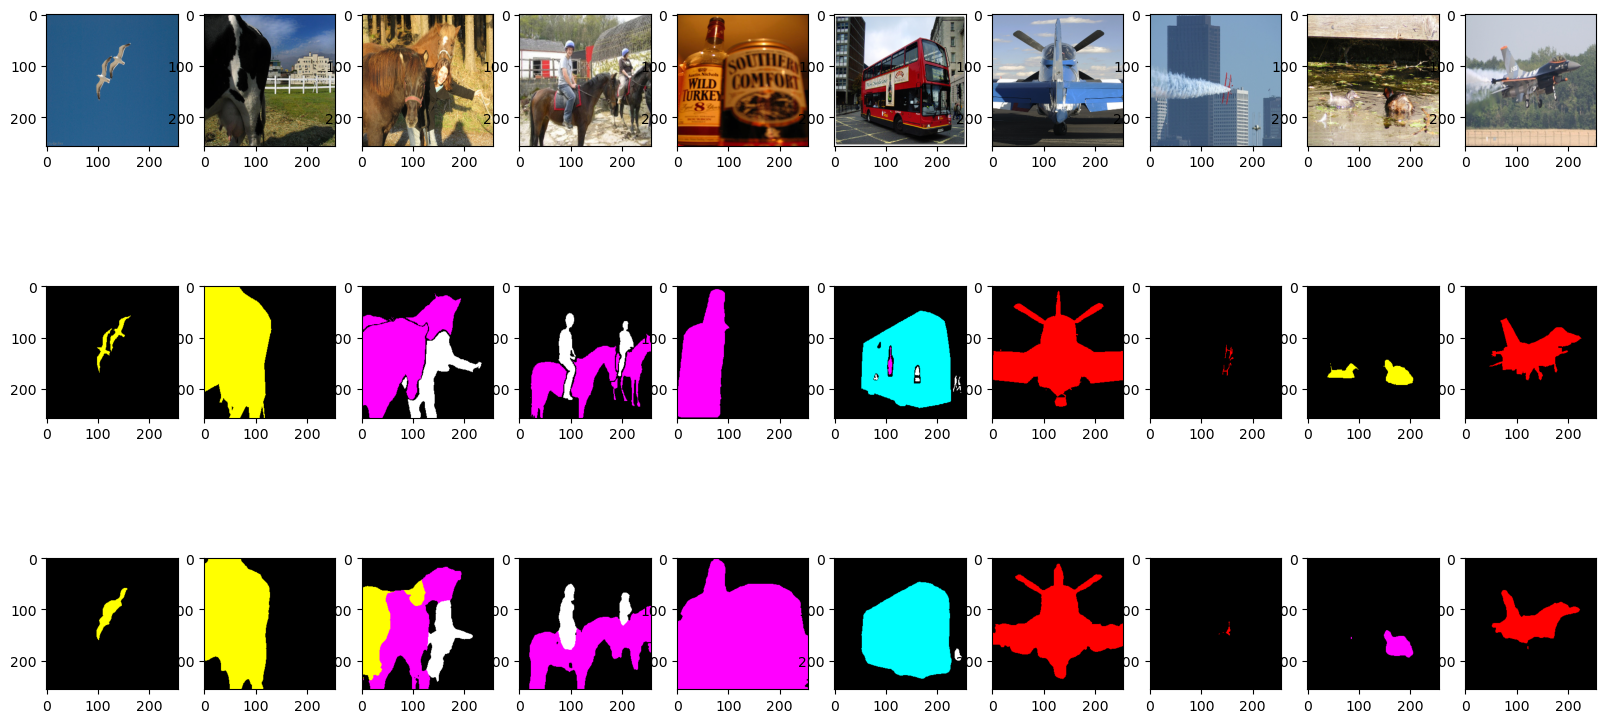

In [20]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None)

indexs: [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..64.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data

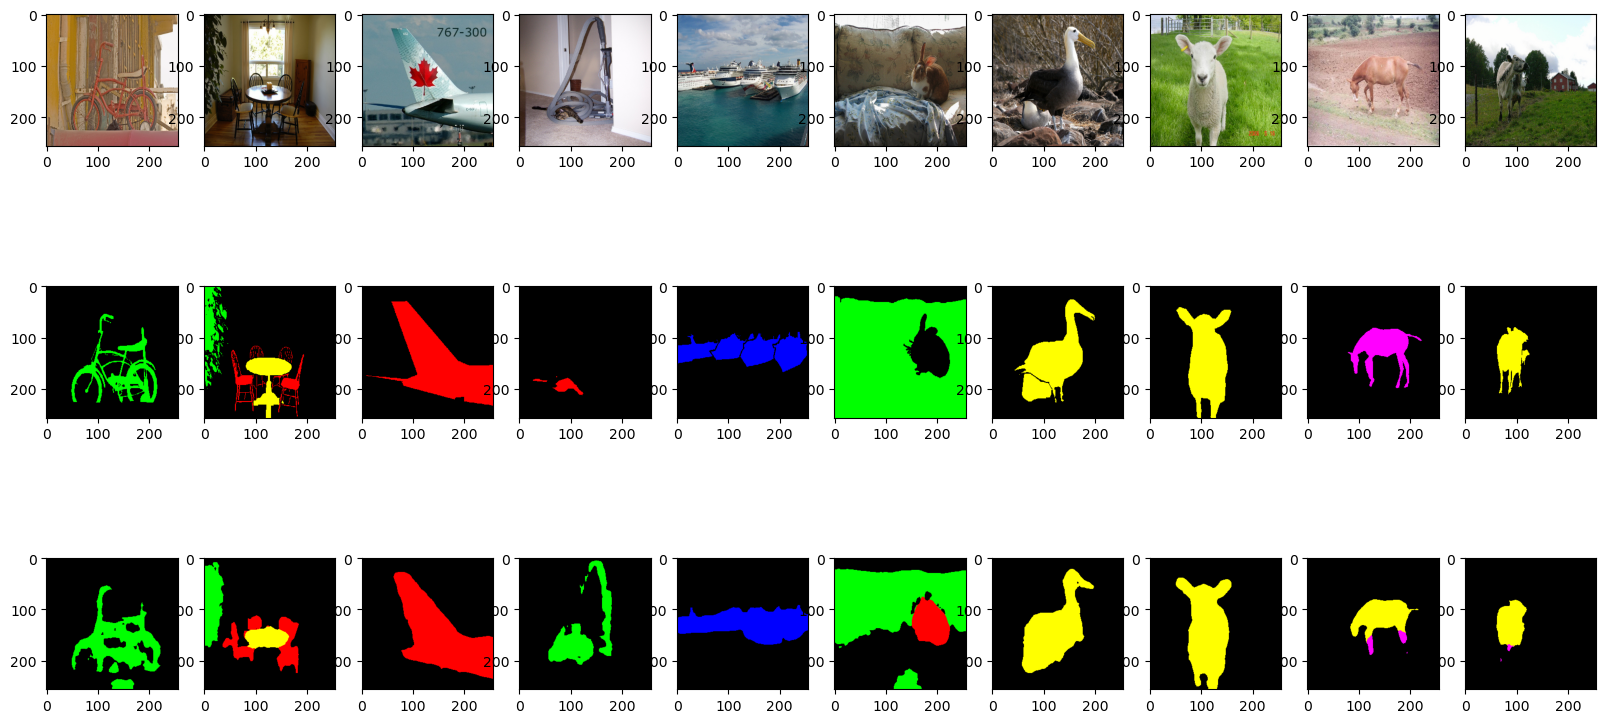

In [21]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753])

indexs: [58, 89, 25, 32, 4, 64, 88, 85, 28, 38]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB dat

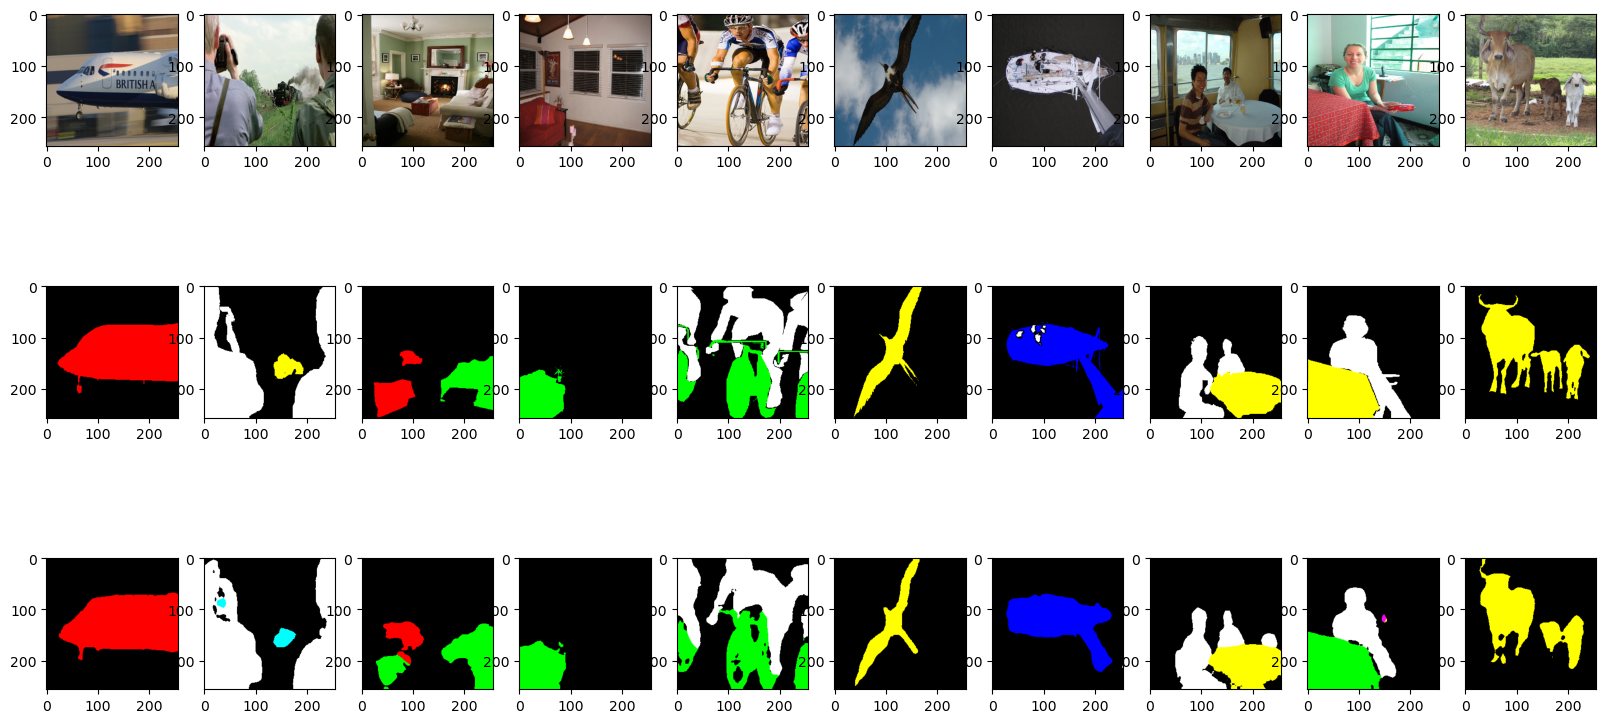

In [22]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [58, 89, 25, 32, 4, 64, 88, 85, 28, 38])